In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('train.csv', index_col=0)

### First data assessment

- 14 continuous features, all between 0 and 1
- A continuous target value
- 300000 entries
- No missing values

In [3]:
df.head(3)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
id,,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 1 to 499999
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont1   300000 non-null  float64
 1   cont2   300000 non-null  float64
 2   cont3   300000 non-null  float64
 3   cont4   300000 non-null  float64
 4   cont5   300000 non-null  float64
 5   cont6   300000 non-null  float64
 6   cont7   300000 non-null  float64
 7   cont8   300000 non-null  float64
 8   cont9   300000 non-null  float64
 9   cont10  300000 non-null  float64
 10  cont11  300000 non-null  float64
 11  cont12  300000 non-null  float64
 12  cont13  300000 non-null  float64
 13  cont14  300000 non-null  float64
 14  target  300000 non-null  float64
dtypes: float64(15)
memory usage: 36.6 MB


### Train test split

In [5]:
target_list = ['target']
feature_list = df.columns.drop(target_list).to_list()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_list], df[target_list], test_size=0.3, random_state=21)

### Visualizing relationships of dependent and independent values
- No clear correlation visible for specific input-target combinations; 'horizontal shape of the plots'
- Some input value regions seem to have more target values than others, e.g. view `cont2`. This is different per feature

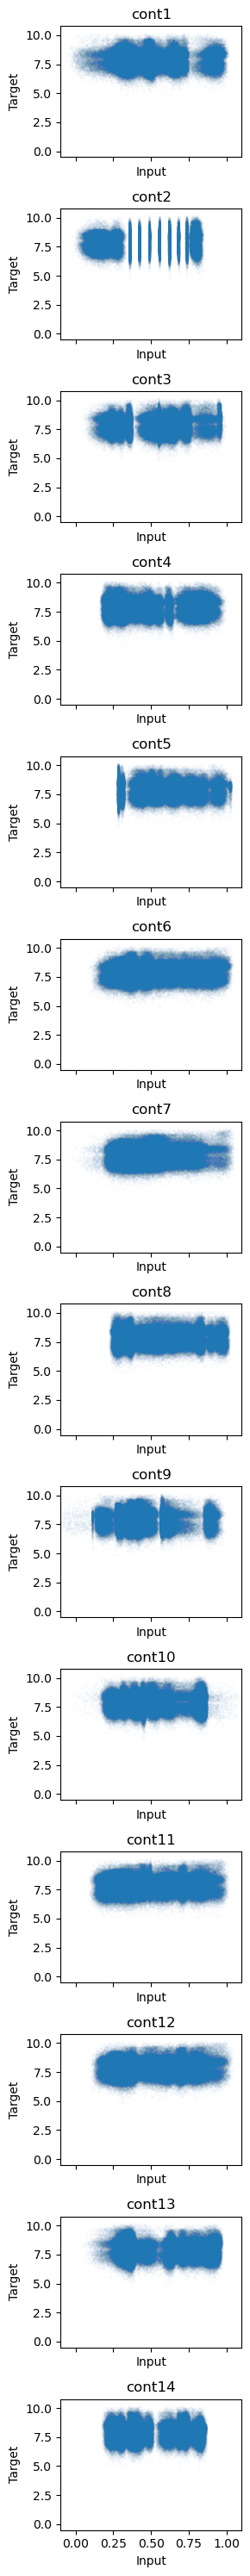

In [7]:
fig, ax = plt.subplots(len(feature_list), 1, figsize = (3, 30), sharex=True)

for i in range(len(feature_list)):
    ax[i].scatter(x = df[feature_list[i]].values, y = df[target_list], alpha = 0.01, s= 1)
    ax[i].set_title(f"{feature_list[i]}")
    ax[i].set_xlabel('Input')
    ax[i].set_ylabel('Target')
    ax[i].set_xlim(-0.1, 1.1)

plt.tight_layout()

In [8]:
# sns.pairplot(df[feature_list].sample(1000))

/home/luukvanroessel/miniconda3/envs/ml-luuk/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='target', ylabel='Count'>

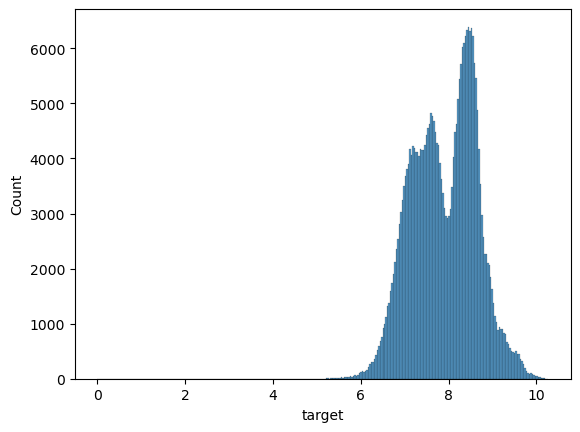

In [8]:
sns.histplot(df.target)

### Create a baseline

- Select the average as the predicted result

In [9]:
def get_results(y_pred, model_name, print_results=True):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    if print_results:
        print(f"{model_name} mean squared error: {mse:.2}")
        print(f"{model_name} r2-score: {r2:.2}, which is a {r2:.2}% reduction in residuals compared to the uniform average")
    return mse, r2

In [10]:
mean_arr = np.ones(len(y_test)) * y_test.mean().iloc[0]
mse_mean, r2_mean = get_results(mean_arr, 'mean_baseline')

mean_baseline mean squared error: 0.54
mean_baseline r2-score: 0.0, which is a 0.0% reduction in residuals compared to the uniform average


### Try to improve using multiple linear regression

result: we se a very minimal improvement compared to estimating using the mean

In [11]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse_baseline, r2_baseline = get_results(y_pred, "multiple_linear_regression")

multiple_linear_regression mean squared error: 0.53
multiple_linear_regression r2-score: 0.019, which is a 0.019% reduction in residuals compared to the uniform average


### Potential improvements

- Pair plot
- Inspect residuals

- Feature selection: forward/backward/mixed selection
- Use decision trees
- Data transformation - ensuring a bell shaped distribution

### Residual plot

- (variance of the) Residuals remain somewhat constant over the fitted value range
- However, it looks like there are two 'residual clusters' (bimodal).
- checkout
    - https://stats.stackexchange.com/questions/569065/dealing-with-bimodal-residuals
    - https://timeseriesreasoning.com/contents/multi-modal-residual-errors/
- Both links resolve the issue of bimodal residuals by including extra features in the model. Unfortunately, there are no extra features available in our case.

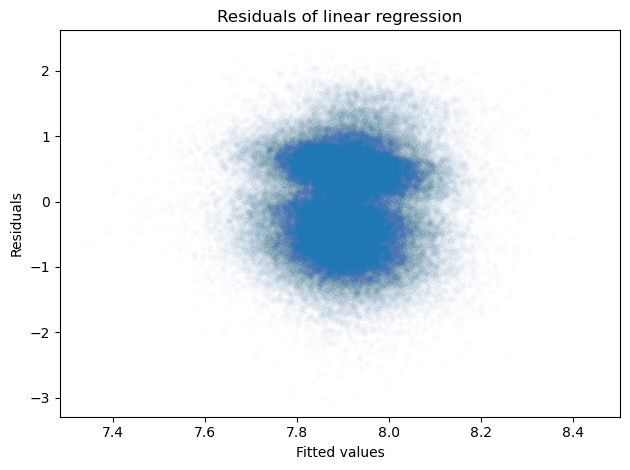

In [12]:
residuals_lin_reg_all = y_test - y_pred

fig, ax = plt.subplots()
ax.scatter(x = y_pred, y = residuals_lin_reg_all, alpha = 0.01, s= 10)
ax.set_title('Residuals of linear regression')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')

plt.tight_layout()

array([[<Axes: title={'center': 'target'}>]], dtype=object)

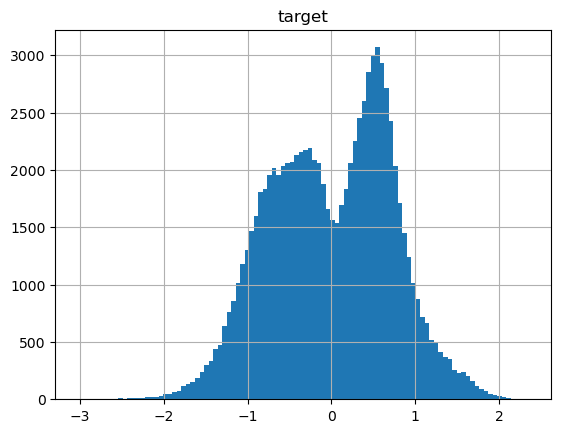

In [15]:
residuals_lin_reg_all.hist(bins = 100)

## Experiment: Playing with binary category

- One approach could be to train a model that can predict to what cluster an observation belongs and extract the 'missing feature' this way.

In [14]:
y_pred_train = reg.predict(X_train)

residuals_lin_reg_all_train = y_train - y_pred_train

X_train['posi_resi'] = 0
X_train['residual'] = residuals_lin_reg_all_train
X_train.loc[X_train['residual'] > 0, 'posi_resi'] = 1

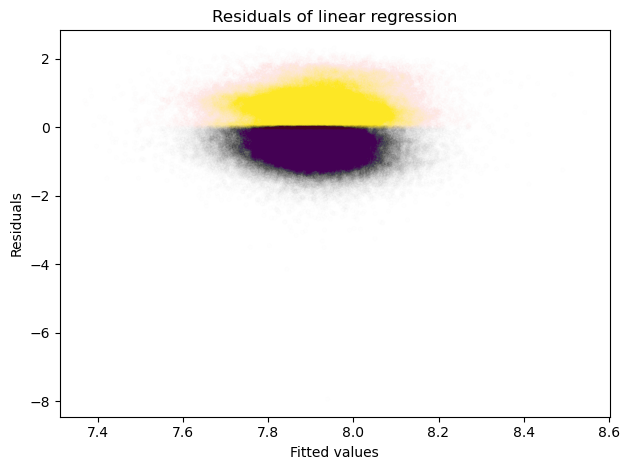

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = y_pred_train, y = residuals_lin_reg_all_train, alpha = 0.005, s= 10, c=X_train['posi_resi'].values)
ax.set_title('Residuals of linear regression')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')

plt.tight_layout()

Unfortunately, the model is not able to correctly predict whether a combination of features result in a positive residual or negative residual. Somehow there is a horizontal separtion visible. I expect to model to become get worse

/home/luukvanroessel/miniconda3/envs/ml-luuk/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


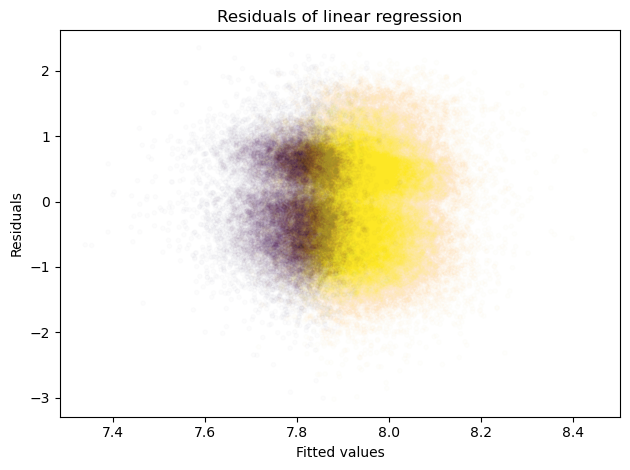

In [16]:
from sklearn.linear_model import LogisticRegression

resid_clf = LogisticRegression()
resid_clf.fit(X_train.drop(columns=['posi_resi', 'residual']).values, X_train['posi_resi'].values)
X_test['posi_resi'] = resid_clf.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(x = y_pred, y = residuals_lin_reg_all, alpha = 0.01, s= 10, c=X_test['posi_resi'].values)
ax.set_title('Residuals of linear regression')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')

plt.tight_layout()

Indeed the model became worse

In [17]:
reg_resid = LinearRegression().fit(X_train.drop(columns='residual'), y_train)
y_pred_resid = reg_resid.predict(X_test)
mse_baseline, r2_baseline = get_results(y_pred_resid, "multiple_linear_regression inc resid categorization")

multiple_linear_regression inc resid categorization mean squared error: 0.87
multiple_linear_regression inc resid categorization r2-score: -0.63, which is a -0.63% reduction in residuals compared to the uniform average


### Apply backward selection 

Our predictions get worse when we drop more features

/tmp/ipykernel_23445/384001172.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  backward_results_df = pd.concat([backward_results_df, pd.DataFrame({'features': [backward_selection_list.copy()], 'mse': mse, 'r2': r2}, index = [i])])


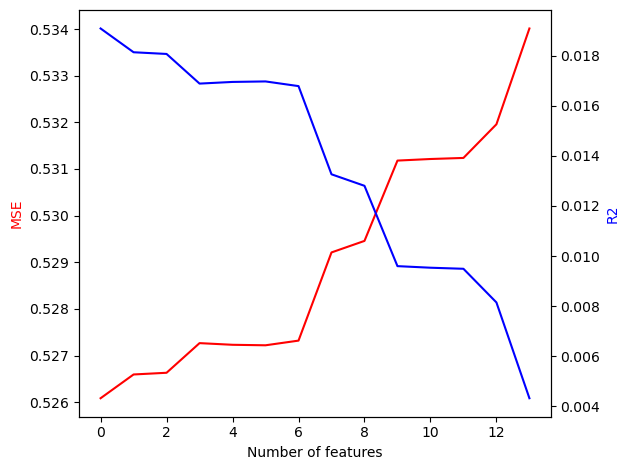

In [14]:
from sklearn.feature_selection import f_regression

backward_results_df = pd.DataFrame(columns=['features', 'mse', 'r2'])

backward_selection_list = feature_list.copy()

for i in range(len(feature_list)):
    X_train_backward = X_train[backward_selection_list]
    X_test_backward = X_test[backward_selection_list]
    reg = LinearRegression().fit(X_train_backward, y_train)
    y_pred = reg.predict(X_test_backward)
    mse, r2 = get_results(y_pred, f"backward_selection_{i}", print_results=False)
    scores, p_values = f_regression(X_train_backward, y_train.values.ravel())
    backward_results_df = pd.concat([backward_results_df, pd.DataFrame({'features': [backward_selection_list.copy()], 'mse': mse, 'r2': r2}, index = [i])])
    least_significant_feature = backward_selection_list[p_values.argmax()]
    backward_selection_list.remove(least_significant_feature)

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(backward_results_df.index, backward_results_df.mse, label='MSE', color='r')
ax2.plot(backward_results_df.index, backward_results_df.r2, label='R2', color='b')
ax.set_xlabel('Number of features')
ax.set_ylabel('MSE', color='r')
ax2.set_ylabel('R2', color='b')
plt.tight_layout()